#Test machine learning models Moentschele Project


## Import modules and create test data

In [ ]:
#Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from collections import Counter
from joblib import dump, load
from skimage import io
from time import sleep
from IPython.display import clear_output
import seaborn as sns
from sklearn import metrics
import re

In [ ]:
#Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"]
wind_force_class_names_short = ["No","Weak","Middle","Strong"]

In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")  # mount google drive

Mounted at /content/drive


In [ ]:
#Function to select Möntschele images by start and end datetime. Returns True if the image is between the datetimes. Format: YYYYMMDD HHSS (e.g. 20220926 1856)
from dateutil.parser import parse

def fn_select_images(from_datetime, to_datetime, image_name):
  #parse inputs to datetime
  from_datetime = parse(from_datetime)
  to_datetime = parse(to_datetime)
  datetime_image = parse(image_name[1:9]+" "+image_name[10:14])
  #return True or False
  return from_datetime < datetime_image < to_datetime

In [ ]:
# define data directory
DATADIR = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/Originals/"

# change: import labels
label_df = pd.read_csv("/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/labels_test_set.csv")
#label_df = pd.read_csv("/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/labels.csv")

label_df = label_df.rename(columns={"Unnamed: 0": "img"})

# retain only labels / img with meaningful label
label_df = label_df[label_df["wind_force"] != "0"]

# array with img names of labeled img
labeled_img = label_df["img"].to_numpy()

# create numeric wind force variable
label_df["wind_force_num"] = np.where(label_df["wind_force"] == "n", 0,
                             np.where(label_df["wind_force"] == "w", 1,
                             np.where(label_df["wind_force"] == "m", 2,
                             np.where(label_df["wind_force"] == "s", 3, -1))))

In [ ]:
# fun to crop img
def fn_crop_image(img_array, y_start, x_start):
    y_heigth = 60 #ursprünglich 80
    x_width = 110
    
    crop_image = img_array[y_start:y_start+y_heigth,x_start:x_start+x_width] # set RGB to 0 to only analyze red chanel
    return crop_image

# Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"] #label_df enthält effektiv nur 4 Kategorien, prüfen! (Problem bei Plot Predictions)

D20221006_124557_3444.jpg


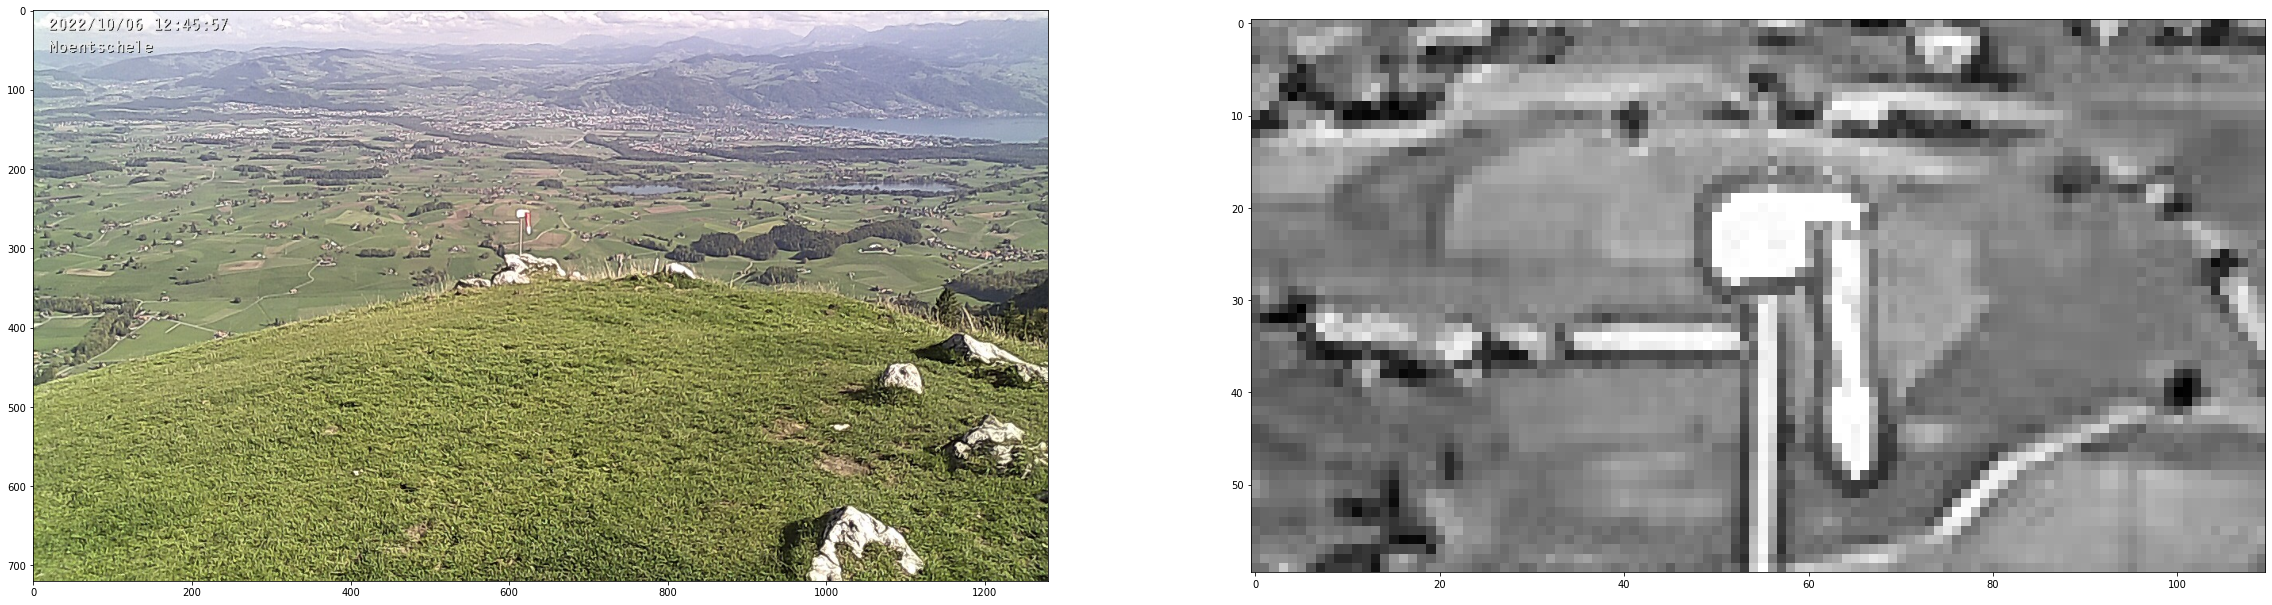

hit enter to continue


In [ ]:
#Show images in labeled_img (used to adjust position of windsock.. (compared with position of trained images))
sleep_seconds = 1
for image_name in labeled_img:
  if fn_select_images(from_datetime="20221006 1240",to_datetime="20221010 0923",image_name=image_name):
    fig = plt.figure(1,figsize= (40,15))
    chart0 = fig.add_subplot(121)
    chart1 = fig.add_subplot(122)
    img_array = cv2.imread(os.path.join(DATADIR+image_name))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
    new_array = fn_crop_image(img_array,233,560)
    new_array = new_array[:,:,0]
    print(image_name)
    chart0.imshow(img_array)
    chart1.imshow(new_array, cmap = 'gray')
    plt.show()
    sleep(sleep_seconds)
    print("hit enter to continue")
    answer = input()
    clear_output()

In [ ]:
# Create Test-Data
test_data = []
def create_test_data():
    for img in labeled_img:
        path = os.path.join(DATADIR, img)
        img_array = cv2.imread(os.path.join(path))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
        new_array = fn_crop_image(img_array, 233, 560)
        wind_label = label_df.loc[label_df["img"] == img, "wind_force_num"] # get label to coresponding img
        wind_label = np.ndarray.item(wind_label.to_numpy()) # convert to single scalar integer
        test_data.append([new_array, wind_label])
    
create_test_data()

images = []
labels = []

for feature, label in test_data:
    images.append(feature)
    labels.append(label)

# mutate to np.array
np_images = np.array(images).reshape(-1, np.array(images).shape[1], np.array(images).shape[2], np.array(images).shape[3])
np_labels = np.array(labels)

#Check counts of labels
Counter(np_labels)

Counter({0: 6, 1: 26, 2: 11})

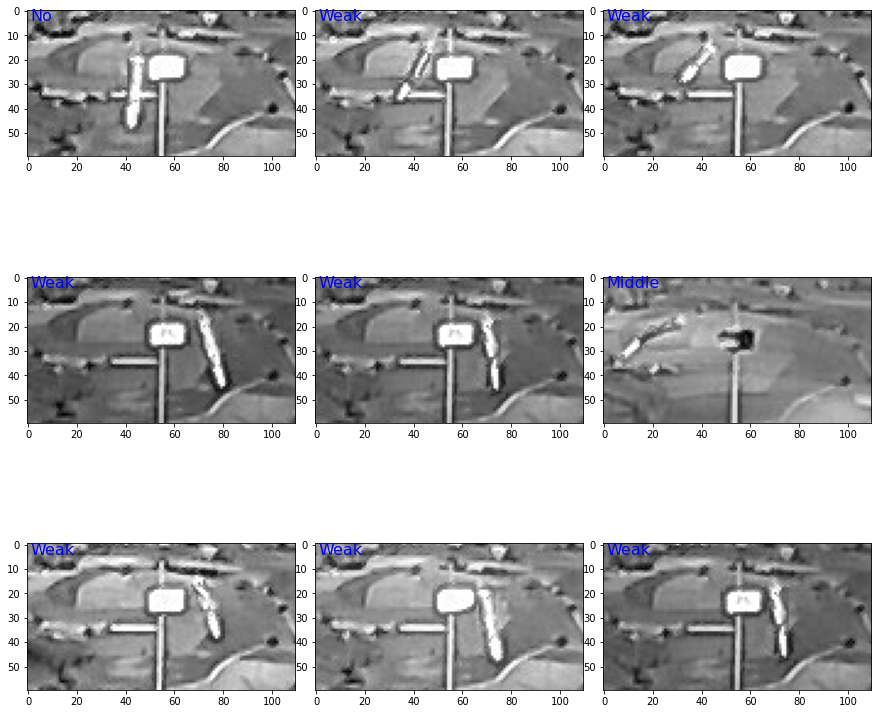

In [ ]:
#Check examples:
n = 3
fig, ax = plt.subplots(n, n, figsize=(4*n, 4*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
np.random.seed(7)
for axi, im_idx in zip(ax, np.random.choice(len(np_images), n**2)):
  im = np_images[im_idx]
  im_class = wind_force_class_names_short[np_labels[im_idx]]
  axi.imshow(im[:,:,0], cmap='gray')
  axi.text(1, 4, f'{im_class}', color='b', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)
plt.show()

In [ ]:
#Convert image shape
label_amount = np_labels.size

print(f"np_images shape: {np_images.shape}")
np_images_red = np_images[:,:,:,0] #reduce to red channel
print(f"np_images_red shape: {np_images_red.shape}")

np_images_red_flatten = np_images_red[:label_amount,:].reshape(label_amount,-1)
print(f"np_images_red_flatten shape: {np_images_red_flatten.shape}")

#1) Split into train and test set:
x_test = np_images_red_flatten
y_test = np_labels

print(f"np_labels shape: {np_labels.shape}")

np_images shape: (43, 60, 110, 3)
np_images_red shape: (43, 60, 110)
np_images_red_flatten shape: (43, 6600)
np_labels shape: (43,)


## Test the models

###Logistic Regression

In [ ]:
loadDir = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/"

#clf_filename = "model_clf_log_reg_noHarm_100.joblib"
#clf_filename = "model_clf_log_reg_noHarm_200.joblib"
#clf_filename = "model_clf_log_reg_noHarm_300.joblib"
#clf_filename = "model_clf_log_reg_noHarm_1000.joblib"
#clf_filename = "model_clf_log_reg_noHarm_2500.joblib"

#clf_filename = "model_clf_log_reg_harm_100.joblib" #°#°°TEMP
#clf_filename = "model_clf_log_reg_harm_200.joblib"
clf_filename = "model_clf_log_reg_harm_2500.joblib"

clf = load(loadDir+clf_filename)

if clf_filename[18:22] == 'harm':
  harmonize = True
  iterations = re.findall('[0-9]+', clf_filename)[0]
  print(f"Harmonized Labels, {iterations} Iterations.")
else:
  harmonize = False
  iterations = re.findall('[0-9]+', clf_filename)[0]
  print(f"Not harmonized Labels, {iterations} Iterations.")

score_test =  clf.score(x_test,y_test)
y_test_pred = clf.predict(x_test)

Harmonized Labels, 2500 Iterations.


### Check classifier performance

In [ ]:
# Create masks for wrong and right predictions and safe corresponding images names to np array
mask_wrong_pred = y_test_pred != y_test
mask_right_pred = y_test_pred == y_test

wrong_image_names = labeled_img[mask_wrong_pred]
right_image_names = labeled_img[mask_right_pred]

print(f"Wrong images: {wrong_image_names.size}, Right labels: {right_image_names.size}, Score: {clf.score(x_test,y_test)}")

Wrong images: 14, Right labels: 29, Score: 0.6744186046511628


In [ ]:
#Get indices of wrong predictions to numpy array
idxs_wrong = np.flatnonzero(mask_wrong_pred)
idxs_right = np.flatnonzero(mask_right_pred)

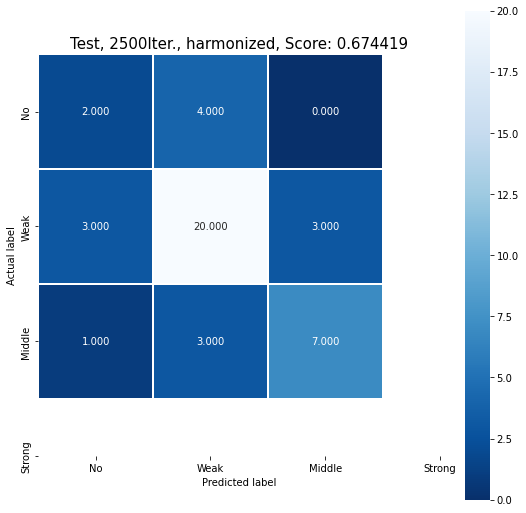

In [ ]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
score = score_test
data_type = "Test"
if harmonize:
  harm = 'harmonized'
else:
  harm = 'not harm.'
plt.figure(figsize=(9,9))
sns.heatmap(cm, xticklabels = wind_force_class_names_short, yticklabels = wind_force_class_names_short, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = data_type + ', ' + str(iterations) + 'Iter., ' + harm + ', ' + 'Score: {:2f}'.format(score)
plt.title(all_sample_title, size = 15);

#### Show images with results

Image: D20221006_152057_4004.jpg, Index: 24


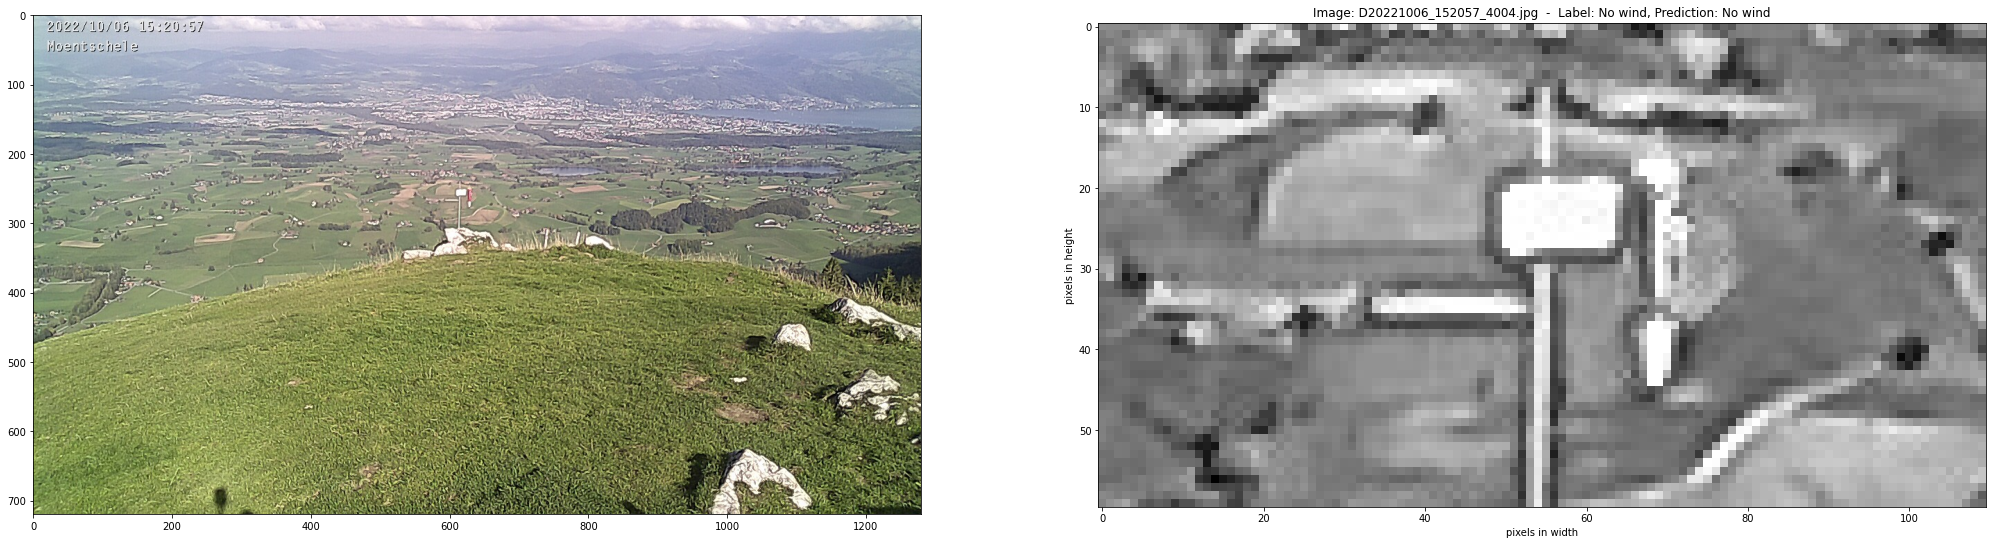

hit enter to continue
enter to continue or type exit..exit


In [ ]:
#Show image examples within matrix:
actual_label = 0
predicted_label = 0
sleep_seconds = 3

for idx in enumerate(y_test_pred):
  idx = idx[0]
  if y_test_pred[idx] == predicted_label and y_test[idx] == actual_label: #use to filter to predicted wind force
    image_name = labeled_img[idx]
    fig = plt.figure(1,figsize= (35,15))
    chart0 = fig.add_subplot(121)
    chart1 = fig.add_subplot(122)
    img_array = cv2.imread(os.path.join(DATADIR+image_name))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
    new_array = fn_crop_image(img_array,233,560)
    new_array = new_array[:,:,0]
    print(f"Image: {image_name}, Index: {idx}")
    plt.title('Image: ' + image_name + '  -  Label: ' + wind_force_class_names[y_test[idx]] + ', Prediction: ' + wind_force_class_names[y_test_pred[idx]])
    plt.xlabel('pixels in width')
    plt.ylabel('pixels in height')
    chart0.imshow(img_array)
    chart1.imshow(new_array, cmap = 'gray')
    plt.show()
    sleep(sleep_seconds)
    print("hit enter to continue")
    answer = input("enter to continue or type exit..")
    if answer == "exit":
      break
    clear_output()

### Linear Regression (Exploration)

In [ ]:
loadDir = "/content/drive/MyDrive/CAS/M3_ML/Project_Moentschele/"
reg_filename = "model_lin_reg_harm.joblib"
#reg_filename = "model_lin_reg_noHarm.joblib"
reg = load(loadDir+reg_filename)

In [ ]:
y_test_pred = reg.predict(x_test)

In [ ]:
# Create masks for wrong and right predictions and safe corresponding images names to np array
mask_wrong_pred = np.rint(y_test_pred) != y_test
mask_right_pred = np.rint(y_test_pred) == y_test

wrong_image_names = labeled_img[mask_wrong_pred]
right_image_names = labeled_img[mask_right_pred]

print(f"Wrong images: {wrong_image_names.size}, Right labels: {right_image_names.size}, Score: {reg.score(x_test,y_test)}")

Wrong images: 29, Right labels: 14, Score: -1.4603855779343444
